# Continuous Control Project

### Import the necessary libraries

The agent is defined in the DDPG_agent.py file and is imported from there.
The Actor and Critic networks are created in the model_pendulum.py file ( The model_pendulum.py file is an adaptation of the model.py file in the ddpg_pendulum folder of udacity DRL repo ). The Actor and Critic networks are used while defining the agent and hence imported in DDPG_agent.py file.

In [1]:
from unityagents import UnityEnvironment 
import numpy as np
from queue import deque
from DDPG_agent import Agent
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")

In [2]:
env = UnityEnvironment(file_name =r'D:\Udacity\Git repo\deep-reinforcement-learning-master\p2_continuous-control\Version1_one agent\Reacher_Windows_x86_64\Reacher.exe')

brain_name = env.brain_names[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Define the Agent

In [5]:
my_agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

cuda:0


### Train and save the model

In [6]:
def continuous_control(n_episodes=1200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,agent = my_agent,brain_name = brain_name,resume = 1,scores = [],scores_window = None):
    """
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    if not scores:
        scores = []                                              # list containing scores from each episode
    if not scores_window:                   
        scores_window = deque(maxlen=100)                        # last 100 scores
    eps = eps_start                                              # initialize epsilon
    for i_episode in range(resume, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
        state = env_info.vector_observations[0]                  # get the current state
        score = 0  
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]  
            next_state = env_info.vector_observations[0]         # get the next state
            reward = env_info.rewards[0]                         # get the reward
            done = env_info.local_done[0]  

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                print(done)
                break 
        scores_window.append(score)                             # save most recent score
        scores.append(score)                                    # save most recent score
        eps = max(eps_end, eps_decay*eps)                       # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'final_checkpoint/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_checkpoint/checkpoint_critic.pth')
            break
        # if i_episode % 100 == 0:
        #     torch.save(agent.actor_local.state_dict(), f'checkpoints2/checkpoint_seed10_actor_{i_episode}.pth')
        #     torch.save(agent.critic_local.state_dict(), f'checkpoints2/checkpoint_seed10_critic_{i_episode}.pth')
        #     with open('checkpoints2/scores.pkl','wb') as s:
        #         pickle.dump(scores,s)
        #     with open('checkpoints2/scores_window.pkl','wb') as s:
        #         pickle.dump(scores_window,s)
            

    return scores

In [7]:
scores = continuous_control()

Episode 10	Average Score: 0.40
Episode 20	Average Score: 0.50
Episode 30	Average Score: 0.62
Episode 40	Average Score: 0.77
Episode 50	Average Score: 0.83
Episode 60	Average Score: 0.99
Episode 70	Average Score: 1.19
Episode 80	Average Score: 1.37
Episode 90	Average Score: 1.51
Episode 100	Average Score: 1.66
Episode 110	Average Score: 2.05
Episode 120	Average Score: 2.47
Episode 130	Average Score: 3.06
Episode 140	Average Score: 3.66
Episode 150	Average Score: 4.30
Episode 160	Average Score: 5.13
Episode 170	Average Score: 5.89
Episode 180	Average Score: 6.54
Episode 190	Average Score: 7.57
Episode 200	Average Score: 8.35
Episode 210	Average Score: 8.99
Episode 220	Average Score: 9.72
Episode 230	Average Score: 10.21
Episode 240	Average Score: 10.72
Episode 250	Average Score: 11.64
Episode 260	Average Score: 12.20
Episode 270	Average Score: 13.02
Episode 280	Average Score: 14.34
Episode 290	Average Score: 15.22
Episode 300	Average Score: 16.18
Episode 310	Average Score: 17.48
Episode 

### Plot the scores

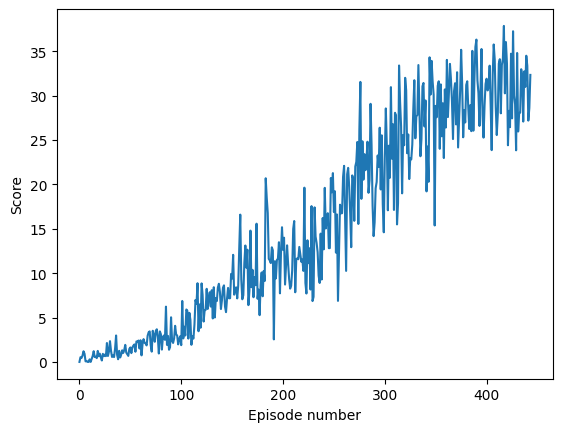

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode number')
plt.show()

### Test the model

* load the checkpoint ( only the weights of 'actor_local' will be required for testing)

    give the path of the model (actor_local) in the variable "actor_local_checkpoint_path"

In [10]:
actor_local_checkpoint_path = r'D:\Udacity\DRL Codes\2nd project\final_checkpoint\checkpoint_actor.pth'
loaded_checkpoint = torch.load(actor_local_checkpoint_path)

# define the agent
my_agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

#load the weights
my_agent.actor_local.load_state_dict(loaded_checkpoint)

cuda:0


<All keys matched successfully>

In [11]:
env_info = env.reset(train_mode=False)[brain_name]

state = env_info.vector_observations[0]
score = 0

while True:
    action = my_agent.act(state)
    # action = int(action)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score+=reward
    state = next_state
    if done: break

print('Score:', score)


Score: 36.8599991761148


In [12]:
env.close()